In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/Strawberry",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1565 files belonging to 2 classes.


In [4]:
class_names=dataset.class_names

In [5]:
class_names

['Strawberry___Leaf_scorch', 'Strawberry___healthy']

In [6]:
len(dataset)

49

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 0 1 0 1 0 0 1 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 1 1 1 0 1 1 0 0]


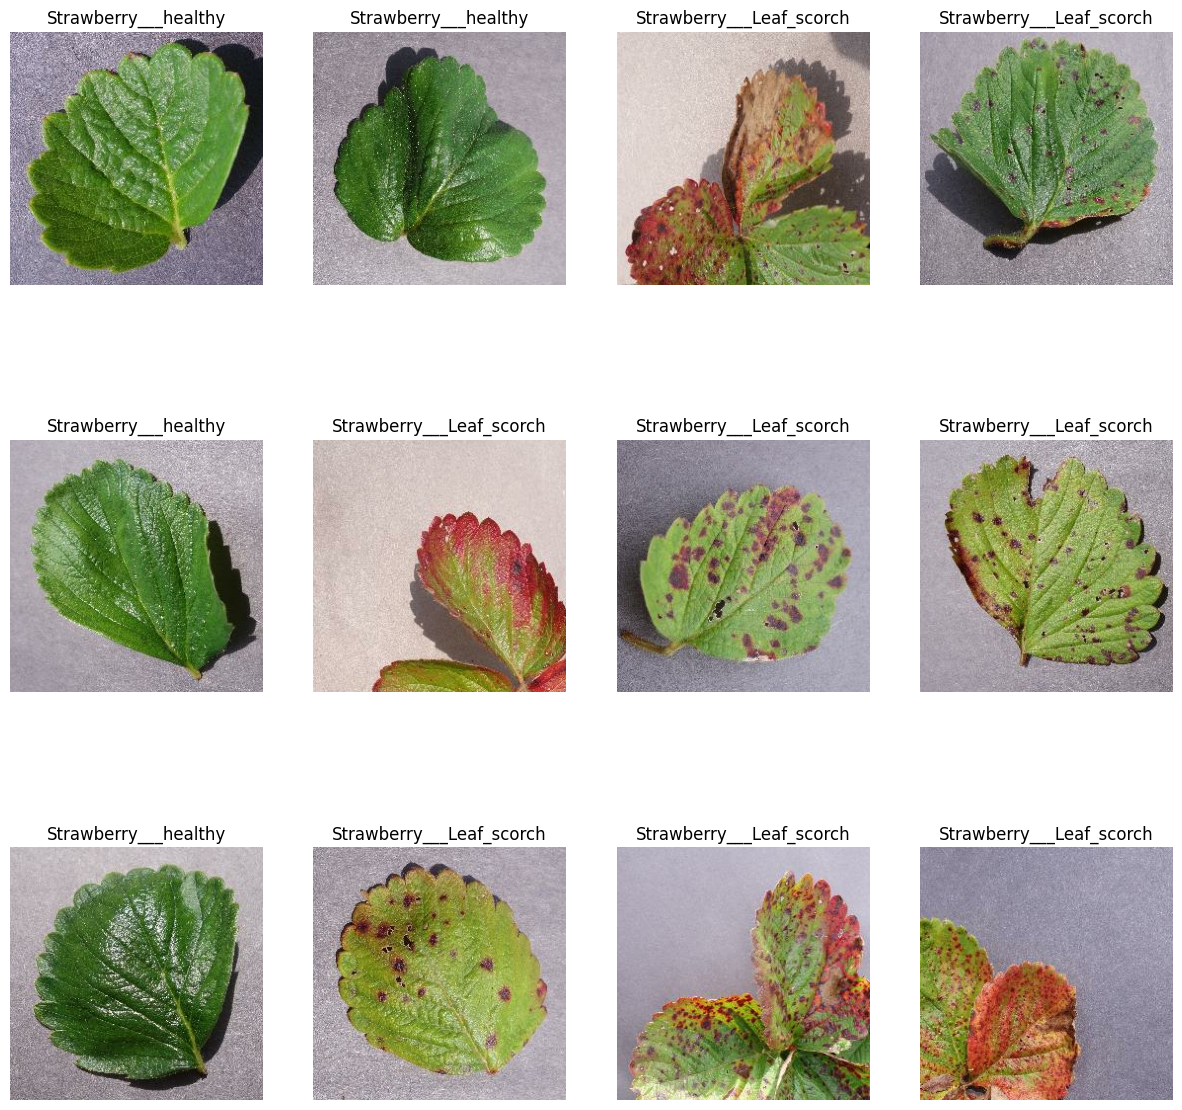

In [8]:
plt.figure (figsize=(15,15 ))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

### Train Test Validate Split

In [9]:
def train_test_valid_split(ds,train_split=0.8,test_split=0.1,val_split=0.1,shuffle=True,shuffle_size=10000):
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    
    train_size=int(len(ds)*train_split)
    test_size=int(len(ds)*test_split)
    
    train_apl=dataset.take(train_size)
    temp_apl=dataset.skip(train_size)
    test_apl=temp_apl.take(test_size)
    val_apl=temp_apl.skip(test_size)
    return train_apl,test_apl,val_apl


In [10]:
train_apl,test_apl,val_apl=train_test_valid_split(dataset)

In [11]:
print(
len(train_apl),
len(test_apl),
len(val_apl)
)

39 4 6


In [12]:
train_apl = train_apl.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_apl = val_apl.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_apl = test_apl.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_n_scale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [14]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

### Modeling

In [15]:
CHANNELS


3

In [16]:
from tensorflow.keras.layers import Input, Add
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=2
def residual_block(x, filters, kernel_size=(3, 3), stride=1):
    """Define a ResNet residual block."""
    # Shortcut
    shortcut = x
    
    # First convolution layer
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    # Second convolution layer
    x = layers.Conv2D(filters, kernel_size, strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    # Adjusting the shortcut for addition
    if stride != 1:
        shortcut = layers.Conv2D(filters, kernel_size=(1, 1), strides=stride)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    
    # Adding the shortcut to the output
    x = Add()([x, shortcut])
    x = layers.Activation("relu")(x)
    
    return x

# Define the model with ResNet architecture
input_tensor = Input(shape=input_shape[1:])

x = resize_n_scale(input_tensor)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

# Using residual blocks
x = residual_block(x, 32)
x = layers.MaxPooling2D((2, 2))(x)
x = residual_block(x, 64, stride=2)
x = residual_block(x, 64)
x = layers.MaxPooling2D((2, 2))(x)
x = residual_block(x, 64)
x = layers.MaxPooling2D((2, 2))(x)
x = residual_block(x, 64)
x = layers.MaxPooling2D((2, 2))(x)
x = residual_block(x, 64)

x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(n_classes, activation='softmax')(x)

model2 = models.Model(inputs=input_tensor, outputs=output)


In [17]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['sequential[0][0]']          
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 32)         9248      ['conv2d[0][0]']              
                                                                                              

                                                                                                  
 batch_normalization_8 (Bat  (None, 32, 32, 64)           256       ['conv2d_9[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 add_3 (Add)                 (None, 32, 32, 64)           0         ['batch_normalization_8[0][0]'
                                                                    , 'max_pooling2d_1[0][0]']    
                                                                                                  
 activation_7 (Activation)   (None, 32, 32, 64)           0         ['add_3[0][0]']               
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 64)           0         ['activation_7[0][0]']        
 g2D)     

In [18]:
model2.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
history = model2.fit(
    train_apl,
    batch_size=BATCH_SIZE,
    validation_data=val_apl,
    verbose=1,
    epochs=10,
)

Epoch 1/10
39/39 [==============================] - 112s 3s/step - loss: 1.7950 - accuracy: 0.8405 - val_loss: 0.6550 - val_accuracy: 0.5079
Epoch 2/10
39/39 [==============================] - 127s 3s/step - loss: 0.2416 - accuracy: 0.9527 - val_loss: 0.7069 - val_accuracy: 0.3333
Epoch 3/10
39/39 [==============================] - 127s 3s/step - loss: 0.2536 - accuracy: 0.9231 - val_loss: 0.6683 - val_accuracy: 0.4603
Epoch 4/10
39/39 [==============================] - 138s 4s/step - loss: 0.2387 - accuracy: 0.9559 - val_loss: 0.6257 - val_accuracy: 0.5185
Epoch 5/10
39/39 [==============================] - 126s 3s/step - loss: 0.2223 - accuracy: 0.9551 - val_loss: 0.3016 - val_accuracy: 0.9418
Epoch 6/10
39/39 [==============================] - 130s 3s/step - loss: 0.1824 - accuracy: 0.9848 - val_loss: 0.4200 - val_accuracy: 0.7831
Epoch 7/10
39/39 [==============================] - 135s 3s/step - loss: 0.1679 - accuracy: 0.9904 - val_loss: 0.3025 - val_accuracy: 0.9365
Epoch 8/10
39

import os
model_version=max([int(i) for i in os.listdir("./models")+[0]])+1
model2.save(f"./models/{model_version}")

In [20]:
model2.evaluate(test_apl)

4/4 [==============================] - 4s 882ms/step - loss: 0.1777 - accuracy: 0.9844


[0.1777152270078659, 0.984375]

### Plotting Accuracy and Loss Curves

In [21]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 39}

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [25]:
acrcy=history.history['accuracy']
val_acrcy=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=10

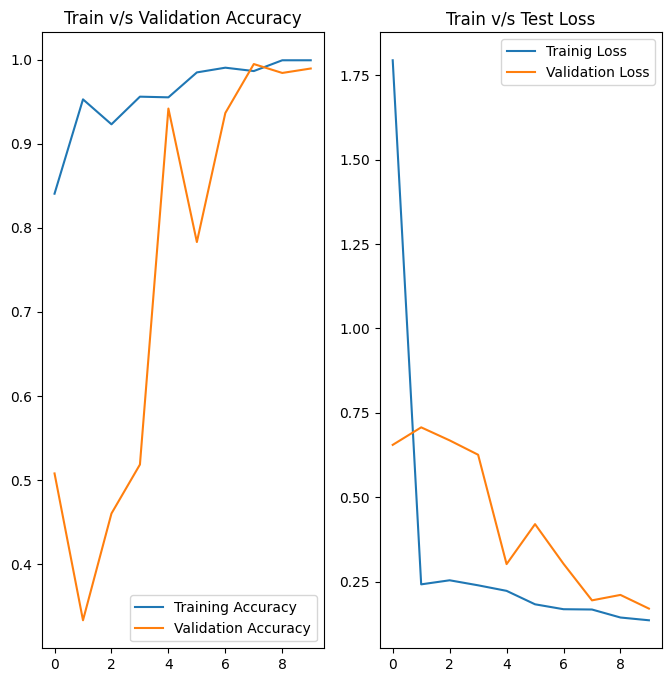

In [26]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs),acrcy,label='Training Accuracy')
plt.plot(range(epochs),val_acrcy,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Train v/s Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(epochs),loss,label='Trainig Loss')
plt.plot(range(epochs),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Train v/s Test Loss')
plt.show()

#### Running prediction on a random image

Image 1:Prediction
Original Label: Strawberry___Leaf_scorch
1/1 [==============================] - 1s 922ms/step
Predicted Label: Strawberry___Leaf_scorch


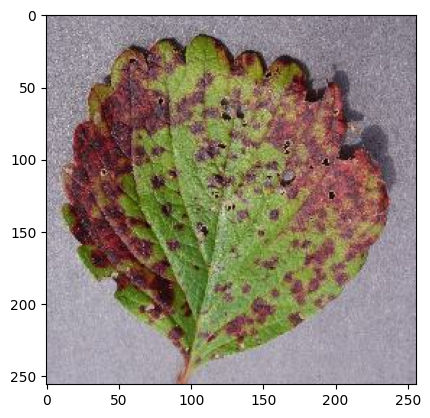

In [29]:
import numpy as np
for images_batch,labels_batch in test_apl.take(1):
    first_img=images_batch[0].numpy().astype('uint8')
    first_lbl=labels_batch[0].numpy()
    
    print("Image 1:Prediction")
    plt.imshow(first_img)
    print("Original Label:",class_names[first_lbl])
    
    pred_lbl=model2.predict(images_batch)
    print("Predicted Label:",class_names[np.argmax(pred_lbl[0])])

#### Creating a function for prediction

In [30]:
def predict(model,img):
    img_arr=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_arr=tf.expand_dims(img_arr,0)
    
    predictions=model.predict(img_arr)
    
    pred_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return pred_class,confidence

##### Running the function to predict disease of multiple images

1/1 [==============================] - 0s 29ms/step


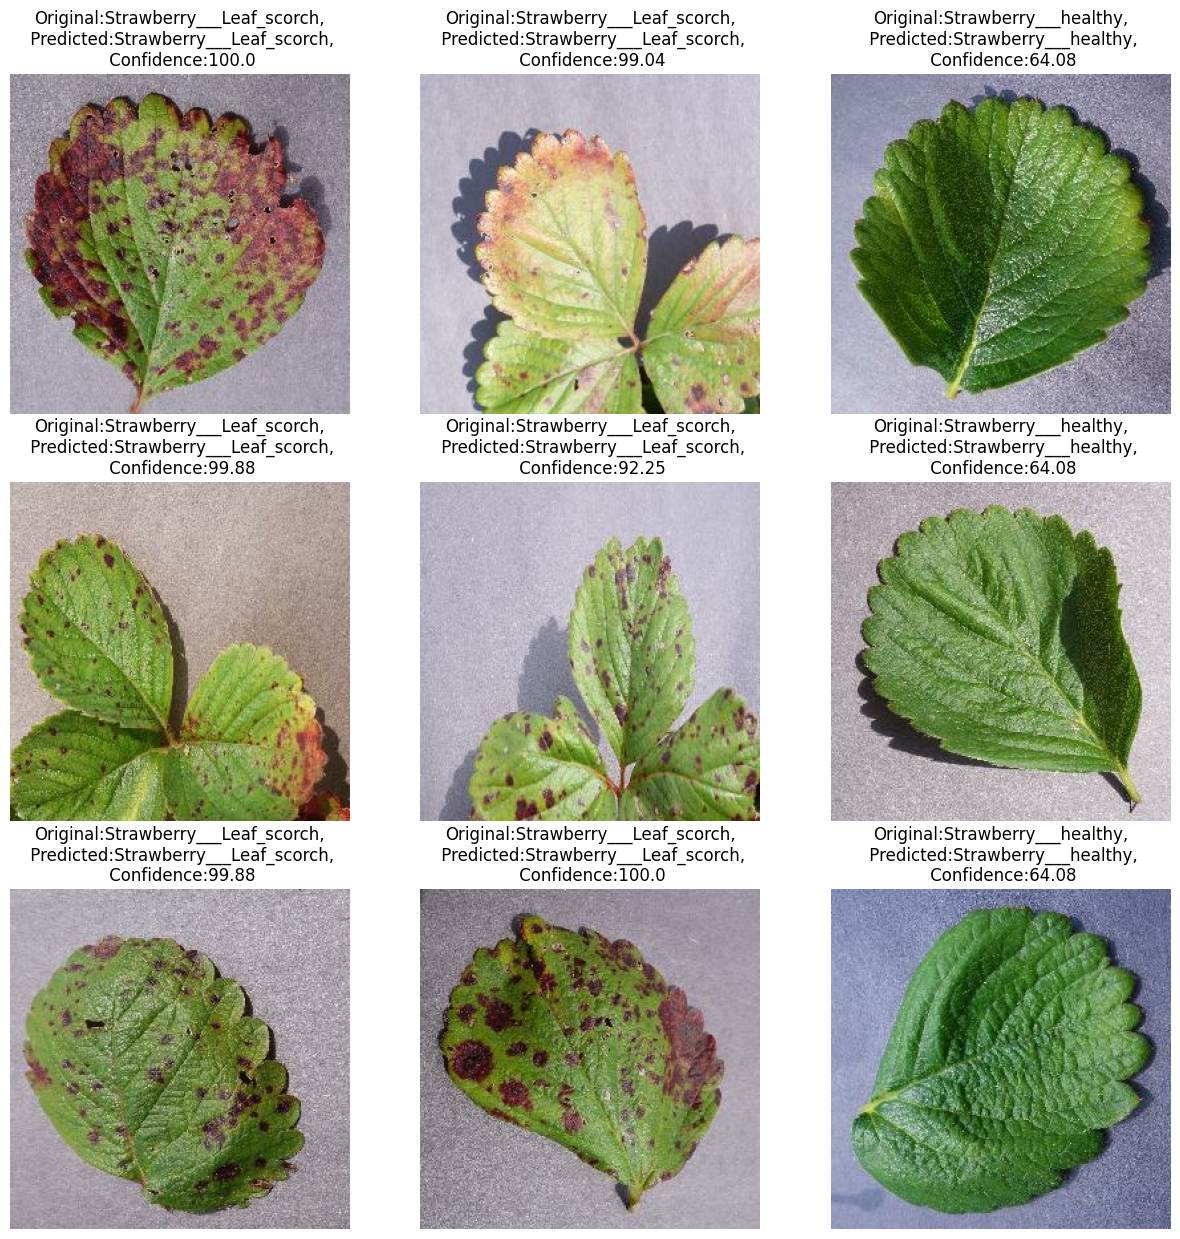

In [35]:
plt.figure(figsize=(15,15))
for images,labels in test_apl.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        pred_class,confidence=predict(model2,images[i].numpy())
        original_class=class_names[labels[i]]
        
        plt.title(f"Original:{original_class},\n Predicted:{pred_class},\n Confidence:{confidence}")
        plt.axis("off")

#### Evaluation matrices

In [59]:
y_pred = model2.predict(test_apl)
y_pred_classes = np.argmax(y_pred, axis=1)


4/4 [==============================] - 3s 638ms/step


In [60]:
y_true = []
for _, label_batch in test_apl:
    y_true.extend(label_batch.numpy())


In [62]:
from sklearn.metrics import classification_report, confusion_matrix

report = classification_report(y_true, y_pred_classes, target_names=class_names)
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print(report)
print(conf_matrix)


                          precision    recall  f1-score   support

Strawberry___Leaf_scorch       0.86      0.84      0.85        87
    Strawberry___healthy       0.67      0.71      0.69        41

                accuracy                           0.80       128
               macro avg       0.77      0.77      0.77       128
            weighted avg       0.80      0.80      0.80       128

[[73 14]
 [12 29]]


In [42]:
pred_labels

0

model2.save("./models/strawberry1")